In [99]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [100]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# Set number of classes

In [101]:
NUM_CLASSES = 4

# 输入长度

In [102]:
TIME_STEPS = 16
DIMENSION = 2

# Dataset reading

In [103]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [104]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [122]:
use_lstm = False    #ture使用 LSTM 层；fluse使用全连接层
model = None

if use_lstm:    #创建一个序列模型 Sequential
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )), #输入层，接收形状为TIME_STEPS * DIMENSION的一维向量作为输入
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )),    #重塑层，将一维向量重塑为TIME_STEPS * DIMENSION的二维张量
        tf.keras.layers.Dropout(0.2),   #以0.2的概率随机丢弃部分神经元，以避免过拟合
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),  #包含16个LSTM单元，输出维度为16
        tf.keras.layers.Dropout(0.5),   #以0.5的概率随机丢弃部分神经元，以避免过拟合
        tf.keras.layers.Dense(10, activation='relu'),   #全连接层，包含10个神经元，激活函数为ReLU
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')    #输出层：包含NUM_CLASSES个神经元，激活函数为Softmax，输出为各类别的概率分布
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [107]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 24)                792       
                                                                 
 dropout_11 (Dropout)        (None, 24)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                250       
                                                                 
 dense_16 (Dense)            (None, 4)                 44        
                                                                 
Total params: 1,086
Trainable params: 1,086
Non-trainable params: 0
_________________________________________________________________


In [108]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [109]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [110]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
30/32 [===========================>..] - ETA: 0s - loss: 1.3793 - accuracy: 0.4440
Epoch 1: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 1s 10ms/step - loss: 1.3787 - accuracy: 0.4466 - val_loss: 1.3537 - val_accuracy: 0.5891
Epoch 2/1000
27/32 [========================>.....] - ETA: 0s - loss: 1.3539 - accuracy: 0.4786
Epoch 2: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 7ms/step - loss: 1.3531 - accuracy: 0.4731 - val_loss: 1.3282 - val_accuracy: 0.5831
Epoch 3/1000
27/32 [========================>.....] - ETA: 0s - loss: 1.3303 - accuracy: 0.5000
Epoch 3: saving model to model/point_history_classifier\point_history_classifier.hdf5
32/32 [==============================] - 0s 7ms/step - loss: 1.3290 - accuracy: 0.5000 - val_loss: 1.2985 - val_accuracy: 0.6276
Epoch 4/1000
29/32 [==========================>...] - ETA: 0s - lo

In [111]:
# 评估模型
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 1ms/step - loss: 0.1806 - accuracy: 0.9660


In [112]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [113]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 47ms/step
[0.9459132  0.01748229 0.01283478 0.02376962]
0


# Confusion matrix（混淆矩阵）

42/42 [==============================] - 0s 1ms/step


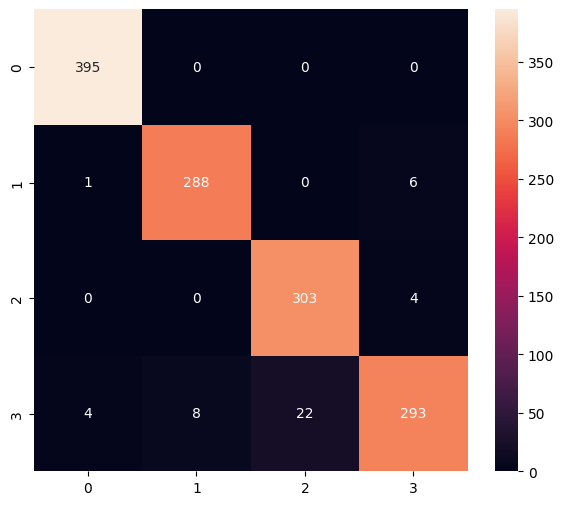

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.97      0.98      0.97       295
           2       0.93      0.99      0.96       307
           3       0.97      0.90      0.93       327

    accuracy                           0.97      1324
   macro avg       0.96      0.96      0.96      1324
weighted avg       0.97      0.97      0.97      1324



In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [115]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)


In [116]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp_n_4c9o0\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp_n_4c9o0\assets


6496

# Inference test（推断测试）

In [117]:
# interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
# interpreter.allocate_tensors()

In [118]:
# # 入出力テンソルを取得
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# print(input_details)

In [119]:
# interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [120]:
# %%time
# # 推論実施
# interpreter.invoke()
# tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [121]:
# print(np.squeeze(tflite_results))
# print(np.argmax(np.squeeze(tflite_results)))